### 1. Preparação dos dados e pacotes necessários para análise

As vezes o pacote do geopandas da problemas nas instalação, essa foi a forma que encontrei para contornar esses problemas

In [ ]:
pip install geopandas

In [2]:
pip uninstall pygeo

In [ ]:
pip install rtree

In [ ]:
pip install googlemaps

Importação de bibliotecas.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# A lista de pacotes é bem extensa
import pandas as pd
import numpy as np
import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import requests
import time
import googlemaps
import glob
import scipy.spatial as spatial
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
from functools import reduce
from datetime import datetime
import re
import os
import shutil
import sys
import linecache
from tqdm.notebook import tqdm_notebook as tqdm # Progress monitoring
import fiona
import geopandas as gpd
from shapely import wkt

Chave da API.

In [ ]:
# API Key do Google Maps
gmaps = googlemaps.Client(key='') 

# Identificar o recorte geográfico

O georreferenciamento tem dois limites: i) é preciso que existam pelos menos 4 locais de votação para que os perímetros possam ser gerados; ii) a API do Google tem um limite de quantos pontos é possível georrefenciar de maneira gratuíta.

In [ ]:
#Carregar a base de locais

dtype = {
 'id_unico':'str',
 'local_unico':'str',
 'lat':'float',
 'lon':'float',
 'fetched_address':'str',
 'precision':'str',
 'LOCAL_VOTACAO':'str',
 'ENDERECO':'str',
 'CEP':'str',
 'COD_LOCALIDADE_IBGE':'str',
 'COD_TSE':'str',
 'LOCALIDADE_LOCAL_VOTACAO':'str',
 'SGL_UF':'str',
 'ZONA':'str',
 'BAIRRO_ZONA_SEDE':'str',
 'NUM_LOCAL':'str',
 'BAIRRO_LOCAL_VOT':'str',
 'COUNTRY':'str',
 'SITUACAO_LOCAL':'str'
 }

locais = pd.read_csv('/content/gdrive/MyDrive/dados/data/locais/local-votacao-08-08-2018-agregado.csv', sep=";", dtype=dtype)

In [ ]:
locais.head(3)

,SGL_UF,COD_LOCALIDADE_IBGE,COD_TSE,LOCALIDADE_LOCAL_VOTACAO,ZONA,NUM_LOCAL,LOCAL_VOTACAO,ENDERECO,BAIRRO_LOCAL_VOT,CEP,COUNTRY,id_unico,lat,lon,fetched_address,precision
0,AC,1200807,01023,PORTO ACRE,1,1015,ESCOLA JOSE PLACIDO DE CASTRO,RUA DEPUTADO RAIMUNDO HERMINIO DE MELO S/N,PORTO ACRE,00000000,BRASIL,01023-1-1015,NaN,NaN,NO_VALUE,NO_VALUE
1,AC,1200807,01023,PORTO ACRE,1,1023,ESCOLA EDMUNDO PINTO DE ALMEIDA NETO,RODOVIA AC 10 KM 29 S/N - VILA DO INCRA,PROJETO HUMAITA,00000000,BRASIL,01023-1-1023,NaN,NaN,NO_VALUE,NO_VALUE
2,AC,1200807,01023,PORTO ACRE,1,1031,ESCOLA PUBLICA JADER SARAIVA MACHADO,PROJETO HUMAITA RAMAL DO V KM 37 S/N,PORTO ACRE,69921000,BRASIL,01023-1-1031,NaN,NaN,NO_VALUE,NO_VALUE


In [ ]:
#Selecionar a base - mesmo escopo da base de votos
locais_selecionados = locais[locais['COD_TSE'] == '71072']

#Lista dos códigos IBGE (COD_LOCALIDADE_IBGE) dos municipios cujos endereços serão georeferenciados
#Precisa ser pelo CÓDIGO DO IBGE, e não pelo código do TSE
municipios_selecionados = locais_selecionados['COD_LOCALIDADE_IBGE'].unique()

In [ ]:
#Segregar somente a base 'locais' com os municipios selecionados
locais_selecionados = locais[locais['COD_LOCALIDADE_IBGE'].isin(municipios_selecionados)]

#Arquivo com todos os municipios do país
mapa_brasil_municipios = gpd.read_file('/content/gdrive/MyDrive/dados/data/shp_municipios-ibge/BR_Municipios_2020.shp')

#Segregar somente o shape dos municipios selecionados
mapa_mun_selecionados = mapa_brasil_municipios[mapa_brasil_municipios['CD_MUN'].isin(municipios_selecionados)]

In [ ]:
#Consolidado do número de locais de votação por cidade selecionada
#Um numero muito pequeno de locais de votação irá gerar uma distorção na aplicação dos voronois
locais_selecionados.pivot_table(index=['LOCALIDADE_LOCAL_VOTACAO', 'COD_LOCALIDADE_IBGE'], values='id_unico', aggfunc='count')

,,id_unico
LOCALIDADE_LOCAL_VOTACAO,COD_LOCALIDADE_IBGE,
SÃO PAULO,3550308,2033


In [ ]:
def mapa_limites(mapa_mun_selecionados):
  #Função que gera os limites (bounds) a serem utilizados como parâmetro da consultar do Google Maps API
  mapa_mun_selecionados = mapa_brasil_municipios[mapa_brasil_municipios['CD_MUN'].isin(municipios_selecionados)]
  bounds = mapa_mun_selecionados.total_bounds
  bounds_google = {'southwest': [bounds[1], bounds[0]], 'northeast' : [bounds[3], bounds[2]]}
  return bounds_google


def exibir_mapa(mapa_mun_selecionados): 
  #Função para exibir o mapa, apenas para visualização
  ax = mapa_mun_selecionados.plot(figsize=(15, 10), color='white', edgecolor='black')
  plt.show()


def mapa_contexto(mapa_mun_selecionados):
  #Função para executar as duas anteriores e retornar o bounds
  bounds = mapa_limites(mapa_mun_selecionados)
  exibir_mapa(mapa_mun_selecionados)
  return bounds

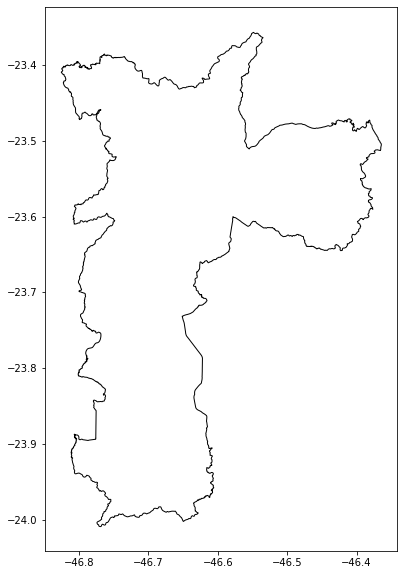

In [ ]:
bounds = mapa_contexto(mapa_mun_selecionados)

In [ ]:
bounds

{'northeast': [-22.500646305, -49.368235342],
 'southwest': [-23.073255077, -49.972525051]}

# Geolocalização endereços

In [ ]:
# Função para localizar os colégios eleitorais que não foram georeferenciados pelo TSE
def get_coordinates(row, query_params, exception_list, bounds):
    ### Essa função deve ser rodada pelo método df.apply() do Pandas
    ### Ela recebe um parâmetro 'query', que se refere ao tipo de busca que queremos realizar.   
    ### Ele deve ser passado na forma de uma lista com a combinação das colunas que vão ser passadas para a API, em ordem.
    ### Considere, por exemplo, query = ['ENDERECO', 'LOCALIDADE_LOCAL_VOTACAO', 'SGL_UF'].
    ### Isso faria uma busca por "Rua A, Cidade B, DF" no Google Maps.
    ### Note que ele checa se a precisão da linha é superior a precisão encontrada na request antes de substituir.
    ### exception_list é necessariamente uma lista vazia, que serve para guardar as exceções item a item.
    
    ##### INÍCIO DAS FUNCIONALIDADES ####
    
    # Aqui, atribuímos um valor numérico para cada uma das possíveis classificações de precisão.
    # Assim, podemos checar se a precisão que recuperamos ao enviar a requisição é melhor que a atual.
    # Se for assim, atualizamos. Caso contrário, mantemos o anterior.
    precision_order = {
                       'TSE':1,
                       'ROOFTOP':2,
                       'RANGE_INTERPOLATED':3,
                       'GEOMETRIC_CENTER':4,
                       'APPROXIMATE':5,
                       'NO_VALUE':6,
                       'ERROR':7,
                      } 
    
    # Agora, precisamos construir a query customizada que foi passada como parâmetro
    query = [str(row[item]).strip() for item in query_params]
    query = ', '.join(query)

    # Com esses parâmetros definidos, já podemos começar a georeferenciar    
    try:
        # Primeiro, verificamos se o item que queremos avaliar já tem uma precisão adequada.
        # Ou seja, se tem uma precisão de nível 1 ou 2 ('TSE' e 'ROOFTOP').
        # Caso positivo, podemos ignorar e manter os valores antigos.
        # Caso contrário, segue para o referenciamento.
        if precision_order[row.precision] < 3:
            lat = row.lat
            lon = row.lon
            precision = row.precision
            fetched_address = row.fetched_address
        
        # Aqui, já sabemos que o item não alcança nosso nível mínimo de precisão.
        else:
            
            # Envia a requisição para o Google.
            geocode_result = gmaps.geocode(query, bounds=bounds)

            # Descobre a precisão do resultado obtido.
            precision = geocode_result[0]['geometry']['location_type']

            # Se a precisão for maior do que a observada, podemos substituir.
            # Essa checagem é importante para evitar que um resultado com precisão 'RANGE_INTERPOLATED'
            # seja trocado por um 'ERROR', por exemplo.
            if precision_order[precision] < precision_order[row.precision]:

                lat = geocode_result[0]['geometry']['location']['lat']
                lon = geocode_result[0]['geometry']['location']['lng']
                fetched_address = geocode_result[0]['formatted_address']

            # Se não, mantemos o valor antigo.
            else:
                lat = row.lat
                lon = row.lon
                precision = row.precision
                fetched_address = row.fetched_address

    # Caso o georeferenciamento falhe, mantemos o valor que existia anteriormente.
    except:
        print('ERROR!')
        print()
        exception_list.append(row.local_unico)
        lat = row.lat
        lon = row.lon
        fetched_address = row.fetched_address
        precision = row.precision
            
    return pd.Series({
        'lon':lon,
        'lat':lat,
        'precision':precision,
        'fetched_address':fetched_address,
    })

In [ ]:
def geocode_each_city(cities, df, query_params, try_no, exception_list, bounds):
    
    ### Essa função roda o código da função get_coordinates(row, query_params, exception_list)
    ### A diferença é que faz isso aos poucos, cidade por cidade, salvando um arquivo sempre que termina.
    ### Os argumentos são os seguintes:
    ### cities: lista de cidades para geolocalizar
    ### df: o dataframe com os locais de votação
    ### query_paramd: a lista de campos que compõe a request que deve ser enviada para o goOGLE
    ### try_no: uma string que vai servir como identificador dos arquivos. Ela, idealmente,
    ### deve ser um número. Assim, conseguimos controlar versões depois de rodar o código diversas vezes
    ### com mudanças na variável query_param.
    ### exception_list: a mesma lista de exceções da função get_coordinates(...)
    
    for city in cities:

        # Cria um df filtrado coma  cidade que queremos
        temp = df[df.COD_LOCALIDADE_IBGE==city]
        
        # Salva os dados para o df filtrado
        data = temp.apply(get_coordinates, args=(query_params,exception_list, bounds), axis=1)
        
        # Passa os dados para o df original
        temp[data.columns] = data
        
        # Salva uma primeira versão para não precisar repetir todo o processo
        temp.to_csv('/content/gdrive/MyDrive/dados/data/geocode/trys/geocode-' + str(try_no) + '-' + 'try' + str(city) + '.csv', index=False)
        
        # Também salva um log de excessões
        newfile = '/content/gdrive/MyDrive/dados/data/geocode/error-logs/errorlog'+ str(try_no) + '-' + 'try' + str(city) + '.txt'
        exception_dump = '\n'.join(exception_list)
        
        with open(newfile, 'w') as outfile:
            outfile.write(exception_dump)

In [ ]:
def concatenate_files(try_no):
    
    ### Essa função lê os arquivos que foram salvos.
    ### Depois, concatena todos os dataframes e retorna uma única variável.
    ### O único argumento é try_no – o mesmo da função geocode.
    ### Sua função é identificar quais arquivos devem ser concantenados.
    
    files = glob.glob("/content/gdrive/MyDrive/dados/data/geocode/trys/geocode-" + str(try_no) + "*.csv")
    dfs = []
    dtype = {
        'SGL_UF':'str', 'COD_LOCALIDADE_IBGE':'str', 'COD_TSE':'str', 'LOCALIDADE_LOCAL_VOTACAO':'str', 'ZONA':'str',
        'BAIRRO_ZONA_SEDE':'str', 'NUM_LOCAL':'str', 'LOCAL_VOTACAO':'str', 
        'ENDERECO':'str', 'BAIRRO_LOCAL_VOT':'str', 'CEP':'str', 'COUNTRY':'str',
        'lat' : 'float', 'lon': 'float',
        'id_unico':'str',
       }
    for file in files:
        df = pd.read_csv(file, dtype=dtype)
        dfs.append(df)
        
    df = pd.concat(dfs)
    return df

In [ ]:
def geocode(cities, df, query_params, try_no, exception_list, bounds):
    geocode_each_city(cities, df, query_params, try_no, exception_list, bounds)
    df = concatenate_files(try_no).reset_index(drop=True) # reset_index para manter índices únicos após a concatenação
    return df

In [ ]:
all_queries = [
    
    ['LOCAL_VOTACAO', 'ENDERECO', 'LOCALIDADE_LOCAL_VOTACAO', 'SGL_UF', 'COUNTRY'],
    ['LOCAL_VOTACAO', 'CEP', 'LOCALIDADE_LOCAL_VOTACAO', 'SGL_UF', 'COUNTRY'],
    ['LOCAL_VOTACAO', 'LOCALIDADE_LOCAL_VOTACAO', 'SGL_UF', 'COUNTRY'],
    ['ENDERECO', 'BAIRRO_LOCAL_VOT', 'LOCALIDADE_LOCAL_VOTACAO', 'CEP', 'SGL_UF', 'COUNTRY'],
    ['ENDERECO', 'CEP', 'LOCALIDADE_LOCAL_VOTACAO', 'SGL_UF', 'COUNTRY'],
    ['ENDERECO', 'LOCALIDADE_LOCAL_VOTACAO', 'SGL_UF', 'COUNTRY'],
    
]

def run(all_queries, df, str_id, bounds):
    
    # Executa tentativas de geocodificação com
    # vários parâmetros possíveis.
    # str_id é um identificador do arquivo final
    
    cities = df.COD_LOCALIDADE_IBGE.unique()
    all_tries = range(1, len(all_queries) + 1)
    
    for query_params, try_no in zip(all_queries, all_tries):
        exception_list = []
        df = geocode(cities, df, query_params, try_no, exception_list, bounds)

    # A função salva apenas o último output, que é o estado dos dados após passar por todas as queries definidas
    df.to_csv("/content/gdrive/MyDrive/dados/data/geocode/consolidados/geocode-" + str_id + '.csv', index=False)

In [ ]:
# STR_ID é a forma como o arquivo concatenando todas as cidades sera identificado
str_id = '71072'

#Roda a query
run(all_queries, locais_selecionados, str_id, bounds)

# Recarregar e tratamento

In [ ]:
# Re-lê o arquivo para reiniciar trabalho
dtype = {
 'id_unico':'str',
 'lat':'float',
 'lon':'float',
 'fetched_address':'str',
 'precision':'str',
 'LOCAL_VOTACAO':'str',
 'ENDERECO':'str',
 'CEP':'str',
 'COUNTRY' : 'str',
 'COD_LOCALIDADE_IBGE' : 'str',
 'LOCALIDADE_LOCAL_VOTACAO':'str',
 'SGL_UF':'str',
 'ZONA':'str',
 'NUM_LOCAL':'str',
 'BAIRRO_LOCAL_VOT':'str',
 'COD_TSE': 'str'}

locais_geocode = pd.read_csv('/content/gdrive/MyDrive/dados/data/geocode/consolidados/geocode-71072.csv', dtype=dtype)

In [ ]:
locais_geocode.head(3)

,SGL_UF,COD_LOCALIDADE_IBGE,COD_TSE,LOCALIDADE_LOCAL_VOTACAO,ZONA,NUM_LOCAL,LOCAL_VOTACAO,ENDERECO,BAIRRO_LOCAL_VOT,CEP,COUNTRY,id_unico,lat,lon,fetched_address,precision
0,SP,3550308,71072,SÃO PAULO,1,1015,COLÉGIO OBJETIVO,"AV. PAULISTA, 900",BELA VISTA,01310100,BRASIL,71072-1-1015,-23.565254,-46.650959,"Av. Paulista, 900 - Bela Vista, São Paulo - SP...",ROOFTOP
1,SP,3550308,71072,SÃO PAULO,1,1023,EE. RODRIGUES ALVES,"AV. PAULISTA, 227",BELA VISTA,01311000,BRASIL,71072-1-1023,-23.570026,-46.646488,"Av. Paulista, 227 - Bela Vista, São Paulo - SP...",ROOFTOP
2,SP,3550308,71072,SÃO PAULO,1,1040,EMEF. CELSO LEITE RIBEIRO FILHO,"RUA HUMAITÁ, 480",BELA VISTA,01321010,BRASIL,71072-1-1040,-23.557313,-46.641760,"R. Humaitá, 480 - Bela Vista, São Paulo - SP, ...",ROOFTOP


In [ ]:
# O que temos, e em que nível de precisão?
locais_geocode.precision.value_counts(normalize=True)

ROOFTOP               0.983768
GEOMETRIC_CENTER      0.009838
RANGE_INTERPOLATED    0.006394
Name: precision, dtype: float64

In [ ]:
#Seleciona somente os locais com precisão ROOFTOP e TSE
locais_selecionados = locais_geocode[locais_geocode.precision.isin(['ROOFTOP', 'TSE'])]

In [ ]:
# Primeiro, aplicamos uma redução de precisão nos pontos encontrados. Queremos que eles sejam precisos até a quarta casa decimal.
# O Google, geralmente, retorna precisão até a sexta
locais_selecionados.loc[:,"lat"] = locais_selecionados.lat.round(4)
locais_selecionados.loc[:,"lon"] = locais_selecionados.lon.round(4)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
locais_selecionados

,SGL_UF,COD_LOCALIDADE_IBGE,COD_TSE,LOCALIDADE_LOCAL_VOTACAO,ZONA,NUM_LOCAL,LOCAL_VOTACAO,ENDERECO,BAIRRO_LOCAL_VOT,CEP,COUNTRY,id_unico,lat,lon,fetched_address,precision
0,SP,3550308,71072,SÃO PAULO,1,1015,COLÉGIO OBJETIVO,"AV. PAULISTA, 900",BELA VISTA,01310100,BRASIL,71072-1-1015,-23.5653,-46.6510,"Av. Paulista, 900 - Bela Vista, São Paulo - SP...",ROOFTOP
1,SP,3550308,71072,SÃO PAULO,1,1023,EE. RODRIGUES ALVES,"AV. PAULISTA, 227",BELA VISTA,01311000,BRASIL,71072-1-1023,-23.5700,-46.6465,"Av. Paulista, 227 - Bela Vista, São Paulo - SP...",ROOFTOP
2,SP,3550308,71072,SÃO PAULO,1,1040,EMEF. CELSO LEITE RIBEIRO FILHO,"RUA HUMAITÁ, 480",BELA VISTA,01321010,BRASIL,71072-1-1040,-23.5573,-46.6418,"R. Humaitá, 480 - Bela Vista, São Paulo - SP, ...",ROOFTOP
3,SP,3550308,71072,SÃO PAULO,1,1058,EE. MARIA JOSÉ,"RUA TREZE DE MAIO, 267",BELA VISTA,01327000,BRASIL,71072-1-1058,-23.5559,-46.6466,"R. Treze de Maio, 267 - Bela Vista, São Paulo ...",ROOFTOP
4,SP,3550308,71072,SÃO PAULO,1,1066,COLÉGIO JOÃO E RAPHAELA PASSALACQUA,"RUA JOÃO PASSALACQUA, 207",BELA VISTA,01326020,BRASIL,71072-1-1066,-23.5549,-46.6454,"Rua João Passalaqua, 207 - Bela Vista, São Pau...",ROOFTOP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,SP,3550308,71072,SÃO PAULO,422,1325,CEI. JARDIM PERI,"RUA AFONSO LOPES VIEIRA, 57",VILA DIONÍSIA,02671100,BRASIL,71072-422-1325,-23.4626,-46.6634,"R. Afonso Lopes Vieira, 57 - 57 - Vila Dionisi...",ROOFTOP
2029,SP,3550308,71072,SÃO PAULO,422,1333,EMEI. SAVA POPOVIC,"RUA FRIBURGO, 12",LAUZANE PAULISTA,02440000,BRASIL,71072-422-1333,-23.4761,-46.6457,"R. Friburgo, 12 - Lauzane Paulista, São Paulo ...",ROOFTOP
2030,SP,3550308,71072,SÃO PAULO,422,1392,COLÉGIO CAETANO ALVARES,"RUA RAMAL DOS MENEZES, 23",VILA SANTO ANTONIO,02469000,BRASIL,71072-422-1392,-23.4855,-46.6414,"R. Ramal dos Menezes, 23 - Lauzane Paulista, S...",ROOFTOP
2031,SP,3550308,71072,SÃO PAULO,422,1414,E.E. MARLY DIVA BONFANTI,"RUA PEDRO OSÓRIO FILHO, 996",VILA NOVA CACHOEIRINHA,02614000,BRASIL,71072-422-1414,-23.4736,-46.6503,"R. Pedro Osório Filho, 996 - Vila Nova Cachoei...",ROOFTOP


In [ ]:
def get_lat_lon_str(row):
    
    # Formata a latitude e longitude sem perder precisão na conversão
    
    lat = "{:.4f}".format(row.lat)
    lon = "{:.4f}".format(row.lon)
    
    lat_lon_str = lat + ', ' + lon
    
    return pd.Series({'lat_lon_str':lat_lon_str})

In [ ]:
locais_selecionados['lat_lon_str'] = locais_selecionados.apply(get_lat_lon_str, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Conta as entradas duplicadas.
# Note o parêametro keep=False, que conta todos os itens e não apenas a primeira das repetições
locais_selecionados.duplicated(subset='lat_lon_str', keep=False).value_counts()

False    1969
True       31
dtype: int64

Caso existam entradas com coordenadas geográficas duplicadas, em alguns casos, isso pode ser correto: dois locais de votação que ocupam prédios diferentes de uma universidade, por exemplo.

A notícia boa é que, como todas elas tem precisão ROOFTOP ou TSE, são muito provalmente duplicatas legítimas, possivelmente locais de votação categorizados de maneira distinta, mas que ocupam o mesmo prédio. Não temos condições de checar todas estas manualmente, então vamos assumir que estão corretas - os votos destas sessões serão agregados.

Outra checagem necessária é ver se todos os pontos que geolocalizamos se encontram nos limites de suas cidades.

Primeiro, precisamos selecionar os mapas das cidades, que pegamos do IBGE.

In [ ]:
mapa_mun_brasil = gpd.read_file('/content/gdrive/MyDrive/dados/data/shp_municipios-ibge/BR_Municipios_2020.shp')
mapa_mun_brasil["NM_MUN"] = mapa_mun_brasil.NM_MUN.astype(str)
mapa_mun_brasil["CD_MUN"] = mapa_mun_brasil.CD_MUN.astype(str)
mapa_mun_brasil.crs = ('EPSG:4326')

In [ ]:
mapa_mun_selecionados = mapa_mun_brasil[mapa_mun_brasil['CD_MUN'].isin(locais_selecionados.COD_LOCALIDADE_IBGE.unique())] #Ajustar o municípios selecionados

In [ ]:
mapa_mun_selecionados

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
3829,3550308,São Paulo,SP,1521.11,"POLYGON ((-46.54624 -23.35791, -46.54585 -23.3..."


As próximas linhas de código determinam se os pontos são válidos, mantendo apenas os que estão dentro dos respectivos municípios. Possivelmente, vamos perder alguns pontos.

In [ ]:
geometry = [ Point( ( row.lon, row.lat ) ) for index, row in locais_selecionados.iterrows() ]
locais_selecionados = gpd.GeoDataFrame( locais_selecionados, geometry = geometry )
locais_selecionados.crs = ('EPSG:4326')

In [ ]:
def validate_points(locais, mapa_mun):
    
# A função remove pontos que, por ventura, tenham sido localizados fora dos limites de suas respectivas cidades.

    to_concat = []
    count = 0
    
    for city_code in tqdm(mapa_mun.CD_MUN.unique() ):
        flag = ''
        this_city = mapa_mun[mapa_mun.CD_MUN == city_code].reset_index(drop=True)
        points = locais[locais.COD_LOCALIDADE_IBGE==city_code].reset_index(drop=True)

        city_name = this_city.loc[0, 'NM_MUN']
        locais_validos = gpd.sjoin(points, this_city, how='inner', predicate='intersects')
        to_concat.append(locais_validos)
        
    locais_validos = pd.concat(to_concat).reset_index(drop=True)
    return locais_validos

In [ ]:
locais_validados = validate_points(locais_selecionados, mapa_mun_selecionados)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
locais_validados

,SGL_UF,COD_LOCALIDADE_IBGE,COD_TSE,LOCALIDADE_LOCAL_VOTACAO,ZONA,NUM_LOCAL,LOCAL_VOTACAO,ENDERECO,BAIRRO_LOCAL_VOT,CEP,...,lon,fetched_address,precision,lat_lon_str,geometry,index_right,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2
0,SP,3550308,71072,SÃO PAULO,1,1015,COLÉGIO OBJETIVO,"AV. PAULISTA, 900",BELA VISTA,01310100,...,-46.6510,"Av. Paulista, 900 - Bela Vista, São Paulo - SP...",ROOFTOP,"-23.5653, -46.6510",POINT (-46.65100 -23.56530),0,3550308,São Paulo,SP,1521.11
1,SP,3550308,71072,SÃO PAULO,1,1023,EE. RODRIGUES ALVES,"AV. PAULISTA, 227",BELA VISTA,01311000,...,-46.6465,"Av. Paulista, 227 - Bela Vista, São Paulo - SP...",ROOFTOP,"-23.5700, -46.6465",POINT (-46.64650 -23.57000),0,3550308,São Paulo,SP,1521.11
2,SP,3550308,71072,SÃO PAULO,1,1040,EMEF. CELSO LEITE RIBEIRO FILHO,"RUA HUMAITÁ, 480",BELA VISTA,01321010,...,-46.6418,"R. Humaitá, 480 - Bela Vista, São Paulo - SP, ...",ROOFTOP,"-23.5573, -46.6418",POINT (-46.64180 -23.55730),0,3550308,São Paulo,SP,1521.11
3,SP,3550308,71072,SÃO PAULO,1,1058,EE. MARIA JOSÉ,"RUA TREZE DE MAIO, 267",BELA VISTA,01327000,...,-46.6466,"R. Treze de Maio, 267 - Bela Vista, São Paulo ...",ROOFTOP,"-23.5559, -46.6466",POINT (-46.64660 -23.55590),0,3550308,São Paulo,SP,1521.11
4,SP,3550308,71072,SÃO PAULO,1,1066,COLÉGIO JOÃO E RAPHAELA PASSALACQUA,"RUA JOÃO PASSALACQUA, 207",BELA VISTA,01326020,...,-46.6454,"Rua João Passalaqua, 207 - Bela Vista, São Pau...",ROOFTOP,"-23.5549, -46.6454",POINT (-46.64540 -23.55490),0,3550308,São Paulo,SP,1521.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,SP,3550308,71072,SÃO PAULO,422,1325,CEI. JARDIM PERI,"RUA AFONSO LOPES VIEIRA, 57",VILA DIONÍSIA,02671100,...,-46.6634,"R. Afonso Lopes Vieira, 57 - 57 - Vila Dionisi...",ROOFTOP,"-23.4626, -46.6634",POINT (-46.66340 -23.46260),0,3550308,São Paulo,SP,1521.11
1995,SP,3550308,71072,SÃO PAULO,422,1333,EMEI. SAVA POPOVIC,"RUA FRIBURGO, 12",LAUZANE PAULISTA,02440000,...,-46.6457,"R. Friburgo, 12 - Lauzane Paulista, São Paulo ...",ROOFTOP,"-23.4761, -46.6457",POINT (-46.64570 -23.47610),0,3550308,São Paulo,SP,1521.11
1996,SP,3550308,71072,SÃO PAULO,422,1392,COLÉGIO CAETANO ALVARES,"RUA RAMAL DOS MENEZES, 23",VILA SANTO ANTONIO,02469000,...,-46.6414,"R. Ramal dos Menezes, 23 - Lauzane Paulista, S...",ROOFTOP,"-23.4855, -46.6414",POINT (-46.64140 -23.48550),0,3550308,São Paulo,SP,1521.11
1997,SP,3550308,71072,SÃO PAULO,422,1414,E.E. MARLY DIVA BONFANTI,"RUA PEDRO OSÓRIO FILHO, 996",VILA NOVA CACHOEIRINHA,02614000,...,-46.6503,"R. Pedro Osório Filho, 996 - Vila Nova Cachoei...",ROOFTOP,"-23.4736, -46.6503",POINT (-46.65030 -23.47360),0,3550308,São Paulo,SP,1521.11


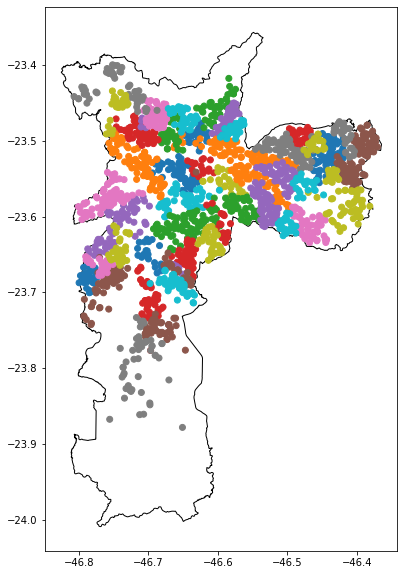

In [ ]:
#Plotando o mapa
ax = mapa_mun_selecionados.plot(figsize=(15, 10), color='white', edgecolor='black')
locais_validados.plot(ax=ax, column='id_unico')
plt.show()

In [ ]:
locais_validados.to_csv("/content/gdrive/MyDrive/dados/data/geocode/validos/geocode-71072.csv", index=False)


# 6. Desenhar diagrama de Voronoi

In [ ]:
#Recarregar as bases de dados
dtype={
    'id_unico':'str', 'local_unico': 'str', 'lat':'float', 'lon':'float' , 'fetched_address': 'str', 'precision': 'str',
    'LOCAL_VOTACAO':'str', 'ENDERECO':'str', 'CEP':'str',
    'COD_LOCALIDADE_IBGE':'str', 'LOCALIDADE_LOCAL_VOTACAO':'str', 'SGL_UF':'str',  
    'ZONA':'str',  'BAIRRO_ZONA_SEDE':'str', 'LATITUDE_ZONA': 'float', 'LONGITUDE_ZONA': 'float',
    'NUM_SECAO':'str', 'NUM_LOCAL':'str','BAIRRO_LOCAL_VOT':'str', 'COUNTRY': 'str', 'CD_MUN': 'str',
    'COD_TSE':'str'}

locais_validados = pd.read_csv("/content/gdrive/MyDrive/dados/data/geocode/validos/geocode-71072.csv", dtype=dtype)     

#Converter a coluna geometry no tipo de dado correto
locais_validados['geometry'] = locais_validados['geometry'].apply(wkt.loads)

#Converter para o CRS correto
locais_validados = gpd.GeoDataFrame(locais_validados, crs='epsg:4326')

In [ ]:
locais_validados

,SGL_UF,COD_LOCALIDADE_IBGE,COD_TSE,LOCALIDADE_LOCAL_VOTACAO,ZONA,NUM_LOCAL,LOCAL_VOTACAO,ENDERECO,BAIRRO_LOCAL_VOT,CEP,...,lon,fetched_address,precision,lat_lon_str,geometry,index_right,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2
0,SP,3550308,71072,SÃO PAULO,1,1015,COLÉGIO OBJETIVO,"AV. PAULISTA, 900",BELA VISTA,01310100,...,-46.6510,"Av. Paulista, 900 - Bela Vista, São Paulo - SP...",ROOFTOP,"-23.5653, -46.6510",POINT (-46.651 -23.5653),0,3550308,São Paulo,SP,1521.11
1,SP,3550308,71072,SÃO PAULO,1,1023,EE. RODRIGUES ALVES,"AV. PAULISTA, 227",BELA VISTA,01311000,...,-46.6465,"Av. Paulista, 227 - Bela Vista, São Paulo - SP...",ROOFTOP,"-23.5700, -46.6465",POINT (-46.6465 -23.57),0,3550308,São Paulo,SP,1521.11
2,SP,3550308,71072,SÃO PAULO,1,1040,EMEF. CELSO LEITE RIBEIRO FILHO,"RUA HUMAITÁ, 480",BELA VISTA,01321010,...,-46.6418,"R. Humaitá, 480 - Bela Vista, São Paulo - SP, ...",ROOFTOP,"-23.5573, -46.6418",POINT (-46.6418 -23.5573),0,3550308,São Paulo,SP,1521.11
3,SP,3550308,71072,SÃO PAULO,1,1058,EE. MARIA JOSÉ,"RUA TREZE DE MAIO, 267",BELA VISTA,01327000,...,-46.6466,"R. Treze de Maio, 267 - Bela Vista, São Paulo ...",ROOFTOP,"-23.5559, -46.6466",POINT (-46.6466 -23.5559),0,3550308,São Paulo,SP,1521.11
4,SP,3550308,71072,SÃO PAULO,1,1066,COLÉGIO JOÃO E RAPHAELA PASSALACQUA,"RUA JOÃO PASSALACQUA, 207",BELA VISTA,01326020,...,-46.6454,"Rua João Passalaqua, 207 - Bela Vista, São Pau...",ROOFTOP,"-23.5549, -46.6454",POINT (-46.6454 -23.5549),0,3550308,São Paulo,SP,1521.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,SP,3550308,71072,SÃO PAULO,422,1325,CEI. JARDIM PERI,"RUA AFONSO LOPES VIEIRA, 57",VILA DIONÍSIA,02671100,...,-46.6634,"R. Afonso Lopes Vieira, 57 - 57 - Vila Dionisi...",ROOFTOP,"-23.4626, -46.6634",POINT (-46.6634 -23.4626),0,3550308,São Paulo,SP,1521.11
1995,SP,3550308,71072,SÃO PAULO,422,1333,EMEI. SAVA POPOVIC,"RUA FRIBURGO, 12",LAUZANE PAULISTA,02440000,...,-46.6457,"R. Friburgo, 12 - Lauzane Paulista, São Paulo ...",ROOFTOP,"-23.4761, -46.6457",POINT (-46.6457 -23.4761),0,3550308,São Paulo,SP,1521.11
1996,SP,3550308,71072,SÃO PAULO,422,1392,COLÉGIO CAETANO ALVARES,"RUA RAMAL DOS MENEZES, 23",VILA SANTO ANTONIO,02469000,...,-46.6414,"R. Ramal dos Menezes, 23 - Lauzane Paulista, S...",ROOFTOP,"-23.4855, -46.6414",POINT (-46.6414 -23.4855),0,3550308,São Paulo,SP,1521.11
1997,SP,3550308,71072,SÃO PAULO,422,1414,E.E. MARLY DIVA BONFANTI,"RUA PEDRO OSÓRIO FILHO, 996",VILA NOVA CACHOEIRINHA,02614000,...,-46.6503,"R. Pedro Osório Filho, 996 - Vila Nova Cachoei...",ROOFTOP,"-23.4736, -46.6503",POINT (-46.6503 -23.4736),0,3550308,São Paulo,SP,1521.11


In [ ]:
mapa_mun_brasil = gpd.read_file('/content/gdrive/MyDrive/dados/data/shp_municipios-ibge/BR_Municipios_2020.shp')
mapa_mun_brasil["NM_MUN"] = mapa_mun_brasil.NM_MUN.astype(str)
mapa_mun_brasil["CD_MUN"] = mapa_mun_brasil.CD_MUN.astype(str)
mapa_mun_brasil.crs = ('EPSG:4326')

mapa_mun_selecionados = mapa_mun_brasil[mapa_mun_brasil['CD_MUN'].isin(locais_validados.COD_LOCALIDADE_IBGE.unique())] #Ajustar o municípios selecionados

## Funções

Com os locais listados, resta desenhar os diagramas de Voronoi. Vamos usar um método baseado [neste](https://github.com/ipython-books/cookbook-2nd-code/blob/master/chapter14_graphgeo/05_voronoi.ipynb) material. O output da função são diversos arquivos .shp, um para cada cidade.

In [ ]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    https://stackoverflow.com/a/20678647/1595060
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        #print(p1, p2)
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [ ]:
def reverse_coords(polygons):
    
    # Reverte as coordenadas que ficaram invertidas após a execução anterior
    
    temp = []
    for polygon in polygons:
        temp_polygon = []
        for vertice in polygon:
            vertice = [vertice[1], vertice[0]]
            temp_polygon.append(vertice)
        temp_polygon = np.array(temp_polygon)
        temp.append(temp_polygon)
    
    return temp

In [ ]:
def merge_polygons(df):
    '''
    Função que leva um geo_df como parâmetro e faz merge em todos os polígonos
     que compartilham um mesmo id. Isso é necessário porque, depois de recortar um polígono voronoi
     contra um contorno de cidade convexo, às vezes acabamos com dois ou mais polígonos para
     um único local.
    
     INPUT: geo_df após calcular a interseção
     SAÍDA: geo_df com polígonos mesclados
    '''
    # Para cada item...
    for index, row in df.iterrows():
        # Seleciona todos os polígonos com o mesmo id
        temp = df[df.id_unico == row.id_unico]
        # Se houver mais de um polígono com o mesmo id
        if temp.shape[0] > 1:
            # Junte todos em apenas um
            new_polygon = temp.unary_union
            # E subistitua no df original
            df.at[index, 'geometry'] = new_polygon
    
    # Depois, derrube as duplicatas desnecessárias
    new_df = df.drop_duplicates(subset='id_unico')
    return new_df

In [ ]:
def make_voronoi_maps(cities, locais, city_maps, exceptions):
    '''
    INPUT:
    cities = array com códigos IBGE
    locais = um geo_df com os pontos de cada local de votação
    city_maps = geo_df com limites de cidades do IBGE
    exeptions = lista vazia que vai ser populada com possíveis erros
    '''
    count = 0
    for index, city in enumerate(tqdm(cities)):
        #print('Making city', city, '-', len(cities) - index, 'cities to go')
        try:
            # Pega o mapa a partir dos arquivos do IBGE
            outline = city_maps[city_maps.CD_MUN==city].reset_index()

            # Seleciona e salva apenas os pontos correspondentes 
            points = locais[locais.CD_MUN==city].reset_index()
            #print("Points selected and saved")

            # Se não houver ao menos três pontos, é impossível computar um voronoi.
            # Nesse caso, em vez de um voronoi, salvamos o próprio outline da cidade
            if points.shape[0] < 4 and points.shape[0] != 1:
                print("Isso não devia acontecer. Caos!")
                print(points.shape[0], 'pontos detectados')
                print(index, city)
                #return

            if points.shape[0] == 1:
                count += 1
                polygons_df = points.copy()
                polygons_df.geometry = outline.geometry
                polygons_df.to_file('/content/gdrive/MyDrive/dados/data/voronois/merge/' + city + '.shp')

            else:
                # Salva os pontos encontrados
                points.to_file('/content/gdrive/MyDrive/dados/data/voronois/pontos-cidade/' + city + '.shp')

                # Isola as latitudes e longitudes em arrays específicos
                lat = points.lat
                lon = points.lon

                # Usa o pacote voronoi do scipy.spatial
                vor = spatial.Voronoi(np.c_[lat, lon])
                # Calcula limites finitos para os voronois retornados pelo scipy
                regions, vertices = voronoi_finite_polygons_2d(vor, 10000)
                # Cria um array com as coordenadas
                polygons = [vertices[region] for region in regions]
                # Reverte para o formato lon/lat
                #print("Reversing coordinates")
                polygons = reverse_coords(polygons)
                # Transforma o np.array em um polígono do shapely
                polygons = [Polygon(polygon) for polygon in polygons]

                # Cria um df com o polígono de cada pontos
                polygons_df = points.copy()
                polygons_df.geometry = polygons

                # Salva uma versão pré-clipar
                polygons_df.crs = ('EPSG:4326')
                polygons_df.to_file('/content/gdrive/MyDrive/dados/data/voronois/pre-clip/' + city + '.shp')

                # Corta os polígonos de voronoi no outline da cidade
                # O overlay padrão do geopandas não parece funcionar, gerando alguns bugs inesperados com float precision.
                # Vamos ter que fazer dentro de um loop usando a função base do shapely, que opera em apenas um polígono de cada vez.
                new_geoseries = []
                poly_list = polygons_df.geometry.tolist()
                outline_geom = outline.loc[0, 'geometry'].buffer(0) # O buffer(0) corrige self-intersections em quatro municípios
                for index, poly in enumerate(poly_list):
                    if not (poly.is_valid and outline_geom.is_valid):
                        print("Problem with geometry validity.")
                        print("poly.is_valid:", poly.is_valid, "outline_geom.is_valid:", outline_geom.is_valid)
                    intersection = poly.intersection(outline_geom)
                    new_geoseries.append(intersection)

                # Salva uma versão clipada
                polygons_df.geometry = new_geoseries
                polygons_df.crs = ('EPSG:4326')
                polygons_df.to_file('/content/gdrive/MyDrive/dados/data/voronois/clipados/' + city + '.shp')


                # Após fazer a clipagem, criam-se polígonos isolados, que pertenciam a um voronoi mas acabaram cortados pelo relevo da cidade.
                # Eles mantém os campos id_unico e lat_lon_str do voronoi, porém. Podemos reagrupá-los a partir daí.
                polygons_df = merge_polygons(polygons_df)
                polygons_df.crs = ('EPSG:4326')
                polygons_df.to_file('/content/gdrive/MyDrive/dados/data/voronois/merge/' + city + '.shp')
                          
        # Captura exceção, printa no console e salva o código da cidade em lista
        except Exception as e:
            exc_type, exc_obj, tb = sys.exc_info()
            f = tb.tb_frame
            lineno = tb.tb_lineno
            filename = f.f_code.co_filename
            linecache.checkcache(filename)
            line = linecache.getline(filename, lineno, f.f_globals)
            exceptions.append(city)
            print("Error", e, "on city code", city)
            print('EXCEPTION IN', lineno, line)
            print()

## Executar

In [ ]:
# Roda a função com todos os códigos de cidade.
# Note que as duplicatas não são derrubadas in place porque elas são necessárias para reunir votos e voronois posteriormente.
cities = locais_validados.COD_LOCALIDADE_IBGE.unique()
exceptions = []
make_voronoi_maps(cities, locais_validados, mapa_mun_selecionados, exceptions)

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


Com os arquivos já salvos, precisamos ler e concatenar todos.

In [7]:
files = glob.glob("/content/gdrive/MyDrive/dados/data/voronois/merge/*.shp")
voronois = pd.concat([gpd.read_file(file) for file in files])
columns = {
 'GEOCOD_IBG': 'COD_IBGE',
 'lat_lon_st': 'geom_str',
 'local_unic': 'loc_unico',
}
voronois = voronois.rename(columns=columns)

NameError: ignored

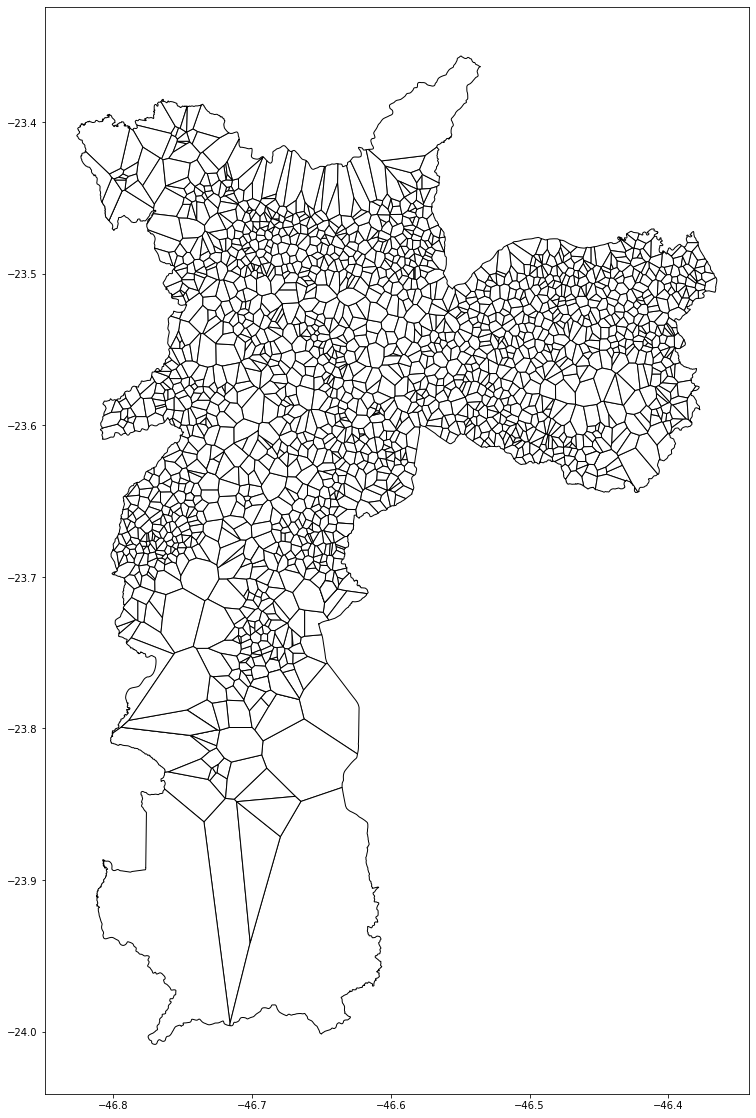

In [8]:
ax = voronois.plot(figsize=(25, 20), color='white', edgecolor='black')
locais_validados.plot(ax=ax, column='id_unico')
plt.show()

In [ ]:
voronois = voronois[['SGL_UF', 'COD_LOCALI', 'COD_TSE', 'LOCALIDADE', 'ZONA',
       'NUM_LOCAL', 'LOCAL_VOTA', 'ENDERECO', 'BAIRRO_LOC', 'CEP', 'COUNTRY',
       'id_unico', 'lat', 'lon', 'geom_str',
       'CD_MUN', 'geometry']]

In [ ]:
voronois

,SGL_UF,COD_LOCALI,COD_TSE,LOCALIDADE,ZONA,NUM_LOCAL,LOCAL_VOTA,ENDERECO,BAIRRO_LOC,CEP,COUNTRY,id_unico,lat,lon,geom_str,CD_MUN,geometry
0,SP,3550308,71072,SÃO PAULO,1,1015,COLÉGIO OBJETIVO,"AV. PAULISTA, 900",BELA VISTA,01310100,BRASIL,71072-1-1015,-23.5653,-46.6510,"-23.5653, -46.6510",3550308,"POLYGON ((-46.65530 -23.56865, -46.65576 -23.5..."
1,SP,3550308,71072,SÃO PAULO,1,1023,EE. RODRIGUES ALVES,"AV. PAULISTA, 227",BELA VISTA,01311000,BRASIL,71072-1-1023,-23.5700,-46.6465,"-23.5700, -46.6465",3550308,"POLYGON ((-46.64608 -23.57233, -46.64810 -23.5..."
2,SP,3550308,71072,SÃO PAULO,1,1040,EMEF. CELSO LEITE RIBEIRO FILHO,"RUA HUMAITÁ, 480",BELA VISTA,01321010,BRASIL,71072-1-1040,-23.5573,-46.6418,"-23.5573, -46.6418",3550308,"POLYGON ((-46.64468 -23.55824, -46.64441 -23.5..."
3,SP,3550308,71072,SÃO PAULO,1,1058,EE. MARIA JOSÉ,"RUA TREZE DE MAIO, 267",BELA VISTA,01327000,BRASIL,71072-1-1058,-23.5559,-46.6466,"-23.5559, -46.6466",3550308,"POLYGON ((-46.64876 -23.55293, -46.64811 -23.5..."
4,SP,3550308,71072,SÃO PAULO,1,1066,COLÉGIO JOÃO E RAPHAELA PASSALACQUA,"RUA JOÃO PASSALACQUA, 207",BELA VISTA,01326020,BRASIL,71072-1-1066,-23.5549,-46.6454,"-23.5549, -46.6454",3550308,"POLYGON ((-46.64611 -23.55219, -46.64304 -23.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,SP,3550308,71072,SÃO PAULO,422,1325,CEI. JARDIM PERI,"RUA AFONSO LOPES VIEIRA, 57",VILA DIONÍSIA,02671100,BRASIL,71072-422-1325,-23.4626,-46.6634,"-23.4626, -46.6634",3550308,"POLYGON ((-46.65888 -23.46243, -46.66542 -23.4..."
1995,SP,3550308,71072,SÃO PAULO,422,1333,EMEI. SAVA POPOVIC,"RUA FRIBURGO, 12",LAUZANE PAULISTA,02440000,BRASIL,71072-422-1333,-23.4761,-46.6457,"-23.4761, -46.6457",3550308,"POLYGON ((-46.64379 -23.48091, -46.64614 -23.4..."
1996,SP,3550308,71072,SÃO PAULO,422,1392,COLÉGIO CAETANO ALVARES,"RUA RAMAL DOS MENEZES, 23",VILA SANTO ANTONIO,02469000,BRASIL,71072-422-1392,-23.4855,-46.6414,"-23.4855, -46.6414",3550308,"POLYGON ((-46.64050 -23.48591, -46.64407 -23.4..."
1997,SP,3550308,71072,SÃO PAULO,422,1414,E.E. MARLY DIVA BONFANTI,"RUA PEDRO OSÓRIO FILHO, 996",VILA NOVA CACHOEIRINHA,02614000,BRASIL,71072-422-1414,-23.4736,-46.6503,"-23.4736, -46.6503",3550308,"POLYGON ((-46.65348 -23.47533, -46.65198 -23.4..."


In [ ]:
voronois.to_file("/content/gdrive/MyDrive/dados/data/voronois/final/" + "71072" + ".shp")